In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import functools
import pickle
from operator import add
import matplotlib as mpl
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import os

In [2]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')

avg92 = jnp.sum(blosum92)/24/24
sum92 = 0.
for row in blosum92:
    for aa in row:
        sum92 += (aa-avg92)**2
std92 = jnp.sqrt(sum92 / 24/24)

def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += (blosum92[idx1][idx2] - avg92)/std92
        #jax.nn.sigmoid(score/len(seqlist1))
    return score/len(seqlist1)
        

In [3]:
seqs = jnp.ones((8, 13, 20))
key = jax.random.PRNGKey(0)

In [4]:
def func(x): 
    x = hk.BatchApply(hk.Linear(64), num_dims=1)(x)
    x = jax.nn.relu(x)
    fwd_core = hk.LSTM(32)
    fwd_outs, fwd_state = hk.dynamic_unroll(fwd_core, x, fwd_core.initial_state(8), reverse=False, time_major=False)
    return fwd_outs

tran_func = hk.transform(func)
params = tran_func.init(key, seqs)
outs = tran_func.apply(params, key, seqs)

In [5]:
print(outs.shape)

(8, 13, 32)


In [25]:
target_seq = 'TARGETPEPTIDE'
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
#c = alpdesign.EnsembleBlockConfig(shape=(16,2), model_number=3)
forward_t, full_forward_t, seq_t , uncertainty_eval_t = alpdesign.build_e2e(c)
#def gen(k, n): return jax.random.normal(k, shape=(n, 13, 20))
train_t = full_forward_t
aconfig = AlgConfig()
c.shape = (
        #64,
        #32,
        16,
        2,)
c.dropout=0.2
c.model_number = 5
aconfig.train_epochs = 30

In [7]:
with open('../10kseqs.txt') as f:
    readfile = f.readlines()
    random_seqs = f'{readfile[0]}'.split(' ')[:-1]
    

def get_blosum_labels(seqs):
    labels = []
    for seq in seqs:
        labels.append(blosum(target_seq, seq))
    labels = np.array(labels)

    return labels

def get_count_labels(seqs):
    return get_aanum(seqs)[:,0]

def get_aanum(seqs):
    aa_count = []
    for seq in seqs:
        seq_list = list(seq)
        aa_num = [float(seq_list.count(aa)) for aa in AA_list]
        aa_count.append(aa_num)
    aa_count = jnp.array(aa_count)
    return aa_count
def get_flat_ohc(seqs):
    return jnp.array([encode_seq(list(s)).flatten() for s in seqs])

def get_ohc(seqs):
    return jnp.array([encode_seq(list(s)) for s in seqs])

batch_size = 8
def get_results(key, params, rep_list):
    means = []
    stds = []
    # need batch
    for i in range(0, len(rep_list)//batch_size):
    #for rep in rep_list:
        batch_reps = rep_list[i * batch_size: (i + 1) * batch_size]
        yhat = forward_t.apply(params, key, batch_reps)
        #print(yhat.shape)
        means.append(yhat[0])
        stds.append(yhat[1])
    return np.array(means), np.array(stds)

def get_single_results(key, params, rep_list):
    yhats = []
    for i in range(0, len(rep_list)//batch_size):
    # need batch
    #for rep in rep_list:
        batch_reps = rep_list[i*batch_size: (i+1)*batch_size]
        yhat = naive_forward_t.apply(params, key, batch_reps)
        yhats.append(yhat)
    return np.array(yhats)

In [21]:
def parity_plot(yhat, test_y, std):
    plt.scatter(test_y, yhat, c='lightskyblue', alpha=0.3)
    plt.errorbar(test_y, yhat, yerr=std, fmt='None', alpha=0.3)
    plt.plot( [-0.5,1.0],[-0.5,1.0], color='lightsalmon', linewidth=2)
    plt.title('Parity Plot')
    plt.xlim([-0.5, 1.0])
    plt.ylim([-0.5, 1.0])
    plt.xlabel('Ground truth')
    plt.ylabel('Predictions')
    plt.text(
    min(test_y) + 0.1,
    max(test_y) - 0.2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
    )
    plt.text(
    min(test_y) + 0.1,
    max(test_y) - 0.3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
    )
    plt.grid()
    return plt


In [10]:
validation_seqs = [random.choice(random_seqs) for i in range(50)]
validation_ohc = get_ohc(validation_seqs)
validation_labels = get_blosum_labels(validation_seqs)
test_seqs = [random.choice(random_seqs) for i in range(500)]
test_ohc = get_ohc(test_seqs)
test_labels = get_blosum_labels(test_seqs)
train_seqs = [random.choice(random_seqs) for i in range(100)]
train_ohc = get_ohc(train_seqs)
train_labels = get_blosum_labels(train_seqs)

In [11]:
print(train_ohc.shape)

(100, 13, 20)


In [ ]:
params, train_loss, val_loss = ensemble_train(
        key, train_t, c, train_ohc, train_labels, val_seqs=validation_ohc, val_labels=validation_labels, aconfig=aconfig
    )

training in progress


Text(0.5, 0, 'epochs')

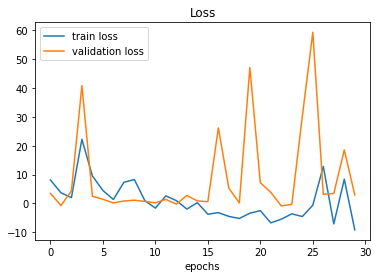

In [14]:
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss')
plt.legend()
plt.xlabel('epochs')

In [23]:
y_pred, y_std = get_results(key, params, test_ohc)
train_y_pred, train_y_std = get_results(key, params, train_ohc)

<module 'matplotlib.pyplot' from '/home/zyang43/.conda/envs/prettyB/lib/python3.9/site-packages/matplotlib/pyplot.py'>

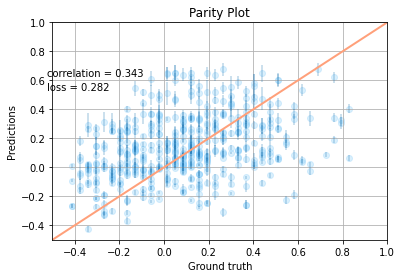

In [22]:
y_pred = y_pred.flatten()
y_std = y_std.flatten()
parity_plot(y_pred, test_labels[:len(y_pred)], y_std)

<module 'matplotlib.pyplot' from '/home/zyang43/.conda/envs/prettyB/lib/python3.9/site-packages/matplotlib/pyplot.py'>

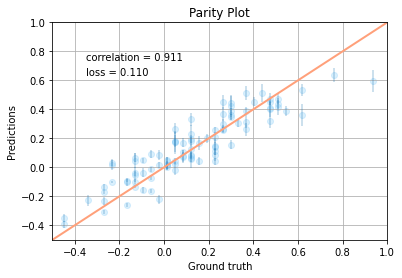

In [24]:
train_y_pred = train_y_pred.flatten()
train_y_std = train_y_std.flatten()
parity_plot(train_y_pred, train_labels[:len(train_y_pred)], train_y_std)